In [2]:
import pandas as pd
from datetime import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

## Read the training data from the zip file into a pandas dataframe

In [3]:
from zipfile import ZipFile
with ZipFile("data/otto-recommender-system.zip", mode="r") as archive:
    for filename in archive.namelist():
        print(filename)
        with archive.open('train.jsonl') as jl:
            chunks = pd.read_json(jl, lines=True, chunksize=1000)
            for c in chunks:
                train_data_df = c
                break

sample_submission.csv
test.jsonl
train.jsonl


In [4]:
train_data_df.head(3)

,session,events
0,0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."


## Expand the 'events' column from a list of events to individual recrods

In [5]:
df_dict = {}
for i, row in (train_data_df).iterrows():
    df_dict[row["session"]] = pd.DataFrame(row["events"])
    df = df_dict[row["session"]]
    df["session_id"] = row["session"]

In [6]:
train_data_df

,session,events
0,0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."
...,...,...
995,995,"[{'aid': 286823, 'ts': 1659304816513, 'type': ..."
996,996,"[{'aid': 1671955, 'ts': 1659304816519, 'type':..."
997,997,"[{'aid': 1814258, 'ts': 1659304816577, 'type':..."
998,998,"[{'aid': 92045, 'ts': 1659304816605, 'type': '..."


In [7]:
all_dfs = [v for k, v in df_dict.items()]
all_dfs_concat = pd.concat(all_dfs)

## Preliminary data exploration:

In [8]:
number_of_aids = all_dfs_concat['aid'].drop_duplicates().count() # Number of unique aids/product Ids
number_of_sessions = all_dfs_concat['session_id'].drop_duplicates().count() # Number of unique user sessions


print(f"Number of unique aids/product Ids:\t{number_of_aids}\nNumber of unique user sessions: \t{number_of_sessions}")


Number of unique aids/product Ids:	36997
Number of unique user sessions: 	1000


In [14]:
# Number of events by event type
event_group = all_dfs_concat.groupby('type')
number_of_events = {grp:len(v) for grp,v in event_group.groups.items()}
print(number_of_events)

{'carts': 6549, 'clicks': 71941, 'orders': 1777}


In [13]:
# Review data for a single session:
session_1_df = pd.DataFrame(train_data_df.iloc[1, 1])

In [5]:
session_1_df.sort_values(["aid", "ts"], ascending=[True, True])

,aid,ts,type
21,50049,1659991115562,clicks
22,105393,1659991156255,clicks
23,105393,1659991168139,carts
10,109488,1659473065576,clicks
28,207905,1661686200666,clicks
16,215311,1659990959575,clicks
17,215311,1659990964841,carts
30,376932,1661705869789,clicks
0,424964,1659304800025,carts
7,424964,1659385993848,clicks


In [6]:
session_1_df.groupby("type").agg(count_action=("aid", "size"))

,count_action
type,
carts,8
clicks,24


In [7]:
session_1_df.loc[:, "ts"] = session_1_df.loc[:, "ts"].apply(
    lambda x: pd.to_datetime(datetime.fromtimestamp(x / 1000))
)

In [8]:
session_1_df.head(8)

,aid,ts,type
0,424964,2022-07-31 17:00:00.025,carts
1,1492293,2022-07-31 17:00:52.871,clicks
2,1492293,2022-07-31 17:01:03.627,carts
3,910862,2022-07-31 17:01:31.923,clicks
4,910862,2022-07-31 17:01:40.209,carts
5,1491172,2022-08-01 15:32:19.248,clicks
6,1491172,2022-08-01 15:32:25.915,carts
7,424964,2022-08-01 15:33:13.848,clicks


In [9]:
session_1_df["time_diff"] = session_1_df["ts"].diff(1)

In [10]:
session_1_df.loc[:, "milliseconds_elapsed"] = session_1_df.loc[:, "time_diff"].apply(
    lambda x: x.total_seconds()
)

In [ ]:
session_1_df

In [12]:
train_data_df.head()

,session,events
0,0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."


In [ ]:
all_dfs_concat.to_parquet("./all_dfs_concat.parquet")

In [43]:
all_dfs_concat.loc[0:10]

,aid,ts,type
session_id,,,
0,1517085,1659304800025,clicks
0,1563459,1659304904511,clicks
0,1309446,1659367439426,clicks
0,16246,1659367719997,clicks
0,1781822,1659367871344,clicks
...,...,...,...
10,967918,1660941383175,clicks
10,218627,1660941816696,clicks
10,766870,1660987307792,clicks


In [2]:
all_dfs_concat = pd.read_pickle("data/all_dfs_concat.pkl")


In [3]:
# all_dfs_concat.loc[:,'time_stamp'] = all_dfs_concat.loc[:,'ts'].apply(lambda x: pd.to_datetime(datetime.fromtimestamp(x/1000)))
all_dfs_concat.loc[:, "time_stamp"] = pd.to_datetime(all_dfs_concat["ts"], unit="ms")


In [4]:
all_dfs_concat.head()


,aid,ts,type,session_id,time_stamp
0,1517085,1659304800025,clicks,0,2022-07-31 22:00:00.025
1,1563459,1659304904511,clicks,0,2022-07-31 22:01:44.511
2,1309446,1659367439426,clicks,0,2022-08-01 15:23:59.426
3,16246,1659367719997,clicks,0,2022-08-01 15:28:39.997
4,1781822,1659367871344,clicks,0,2022-08-01 15:31:11.344


In [5]:
(all_dfs_concat["type"]) = (all_dfs_concat["type"]).astype("category")


In [6]:
all_dfs_concat.head()


,aid,ts,type,session_id,time_stamp
0,1517085,1659304800025,clicks,0,2022-07-31 22:00:00.025
1,1563459,1659304904511,clicks,0,2022-07-31 22:01:44.511
2,1309446,1659367439426,clicks,0,2022-08-01 15:23:59.426
3,16246,1659367719997,clicks,0,2022-08-01 15:28:39.997
4,1781822,1659367871344,clicks,0,2022-08-01 15:31:11.344


In [7]:
# total number of actions per session
all_dfs_concat.groupby("session_id").agg(count_action=("aid", "size"))


,count_action
session_id,
0,276
1,32
2,33
3,226
4,19
...,...
99995,21
99996,302
99997,112


In [8]:
# calculate the total number orders per session
orders_count_aid = (
    all_dfs_concat[all_dfs_concat["type"] == "orders"]
    .groupby("aid")
    .agg(total_orders=("aid", "size"))
    .sort_values("total_orders", ascending=False)
)


In [9]:
# calculate the total number orders per session
all_dfs_concat_actions_count = (
    all_dfs_concat.groupby(["type", "aid"])
    .agg(total_types=("aid", "size"))
    .sort_values("total_types", ascending=False)
)
all_dfs_concat_actions_count.reset_index(inplace=True)


In [10]:
all_dfs_concat_actions_count.head()


,type,aid,total_types
0,clicks,29735,3266
1,clicks,832192,2898
2,clicks,108125,2800
3,clicks,1733943,2638
4,clicks,1603001,2588


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 [Text(0, 0, '29735'),
  Text(1, 0, '832192'),
  Text(2, 0, '108125'),
  Text(3, 0, '1733943'),
  Text(4, 0, '1603001'),
  Text(5, 0, '554660'),
  Text(6, 0, '166037'),
  Text(7, 0, '1460571'),
  Text(8, 0, '247240'),
  Text(9, 0, '80222'),
  Text(10, 0, '184976'),
  Text(11, 0, '332654'),
  Text(12, 0, '1083665'),
  Text(13, 0, '1116095'),
  Text(14, 0, '1743151'),
  Text(15, 0, '959208'),
  Text(16, 0, '714524'),
  Text(17, 0, '1498443'),
  Text(18, 0, '673407'),
  Text(19, 0, '1022566'),
  Text(20, 0, '803928'),
  Text(21, 0, '508883'),
  Te

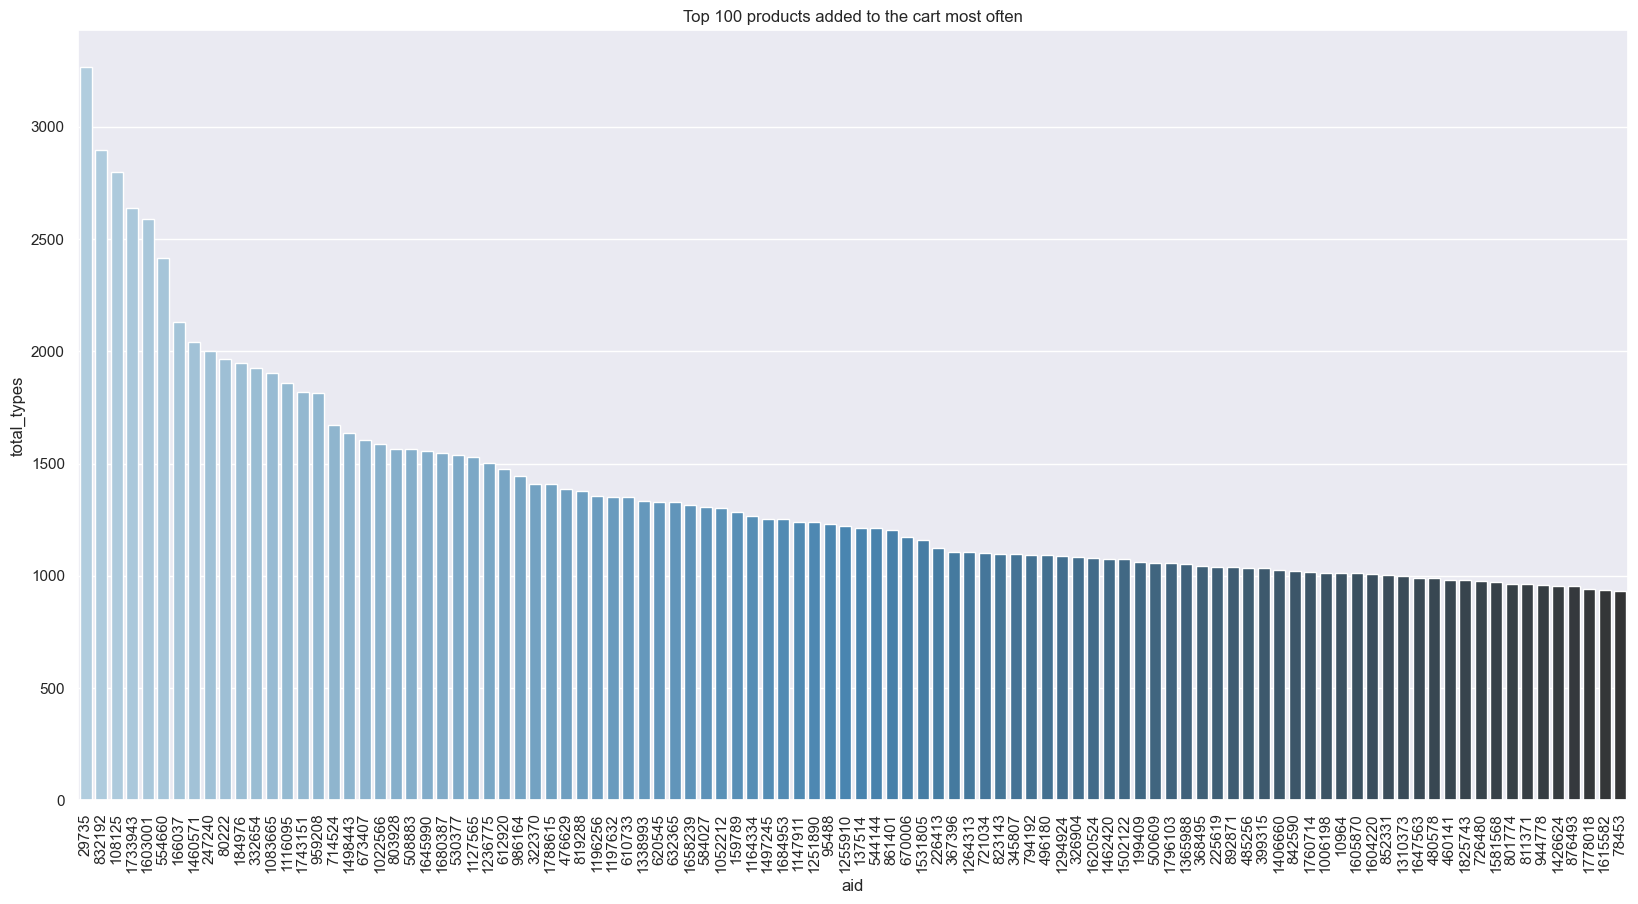

In [11]:
all_dfs_concat_actions_count[all_dfs_concat_actions_count["type"] == "orders"]
# plot the top 100 products with the most orders
plt.figure(figsize=(20, 10))
sns.barplot(
    x="aid",
    y="total_types",
    data=all_dfs_concat_actions_count[all_dfs_concat_actions_count["type"] == "clicks"][
        0:100
    ],
    palette="Blues_d",
    order=all_dfs_concat_actions_count[
        all_dfs_concat_actions_count["type"] == "clicks"
    ]["aid"][0:100],
)
plt.title("Top 100 products added to the cart most often")
plt.xticks(rotation=90)


In [12]:
orders_count_aid.reset_index(inplace=True)
orders_count_aid.head()


,aid,total_orders
0,80222,127
1,1022566,106
2,166037,94
3,1629608,76
4,1733943,75


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 [Text(0, 0, '80222'),
  Text(1, 0, '1022566'),
  Text(2, 0, '166037'),
  Text(3, 0, '1629608'),
  Text(4, 0, '1733943'),
  Text(5, 0, '332654'),
  Text(6, 0, '351335'),
  Text(7, 0, '923948'),
  Text(8, 0, '1603001'),
  Text(9, 0, '544144'),
  Text(10, 0, '1083665'),
  Text(11, 0, '832192'),
  Text(12, 0, '29735'),
  Text(13, 0, '231487'),
  Text(14, 0, '563117'),
  Text(15, 0, '247240'),
  Text(16, 0, '673407'),
  Text(17, 0, '125278'),
  Text(18, 0, '800391'),
  Text(19, 0, '527209'),
  Text(20, 0, '1379013'),
  Text(21, 0, '631899'),
  Text

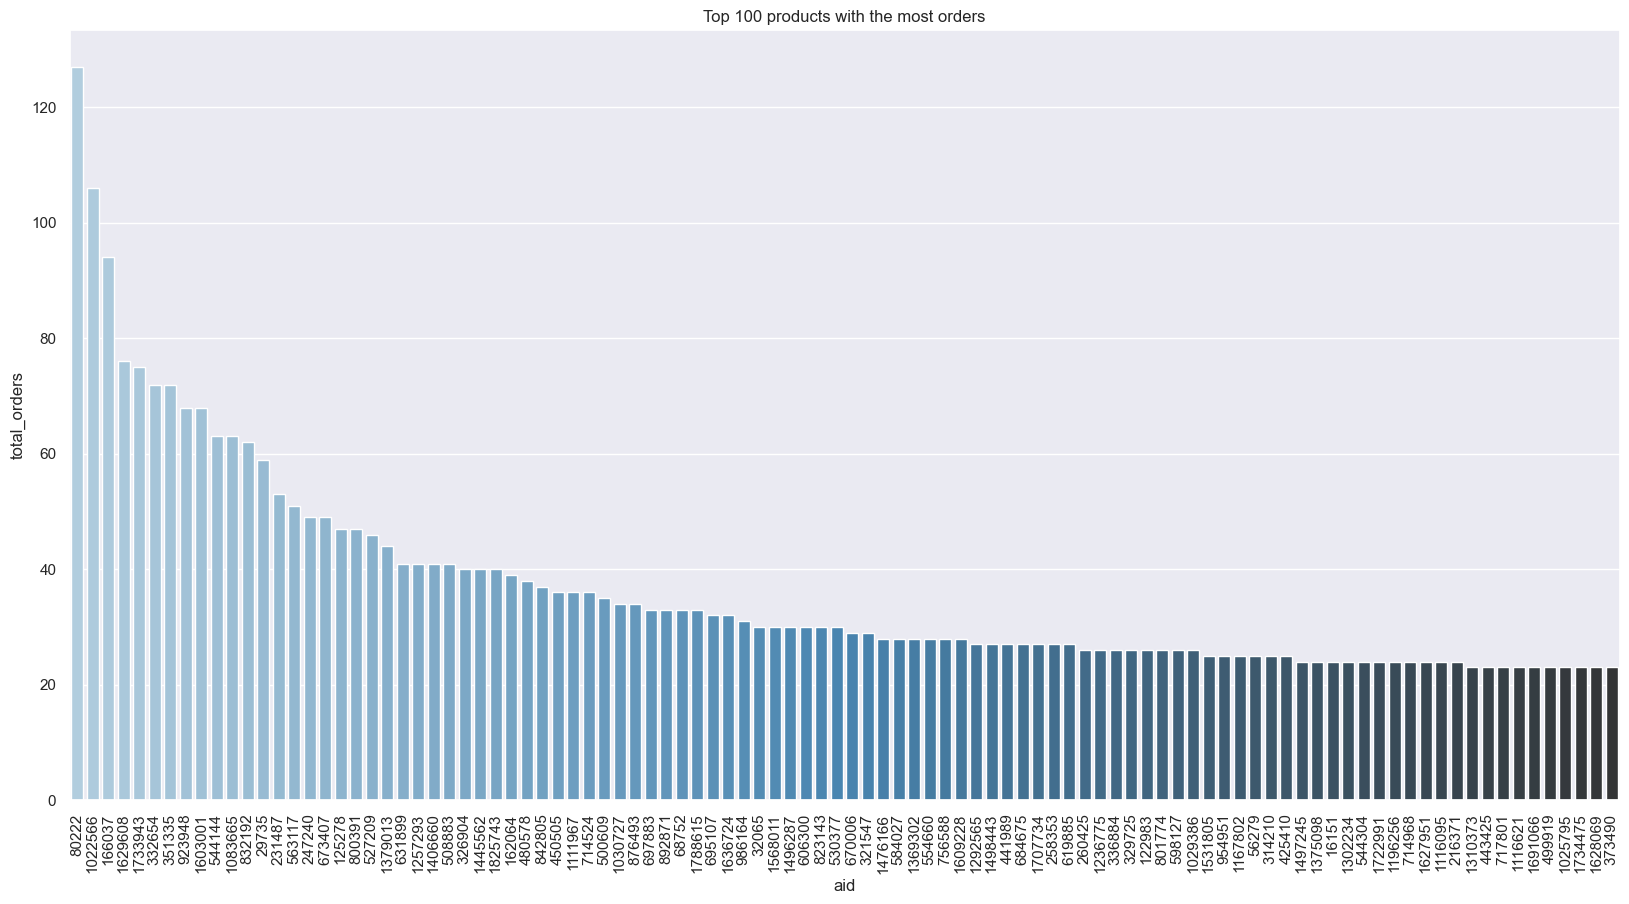

In [13]:
# plot the top 100 products with the most orders
plt.figure(figsize=(20, 10))
sns.barplot(
    x="aid",
    y="total_orders",
    data=orders_count_aid[0:100],
    palette="Blues_d",
    order=orders_count_aid["aid"][0:100],
)
plt.title("Top 100 products with the most orders")
plt.xticks(rotation=90)


Text(0, 0.5, 'Frequency')

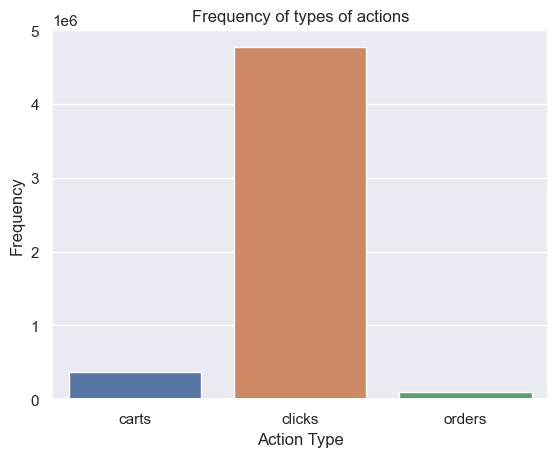

In [14]:
# plot the frequency of types of actions

sns.countplot(x="type", data=all_dfs_concat)
plt.title("Frequency of types of actions")
plt.xlabel("Action Type")
plt.ylabel("Frequency")


In [15]:
all_dfs_concat_session_length = all_dfs_concat.groupby("session_id").agg(
    session_length_secs=("time_stamp", lambda x: (x.max() - x.min()).total_seconds())
)

Text(-8.680555555555555, 0.5, 'Frequency')

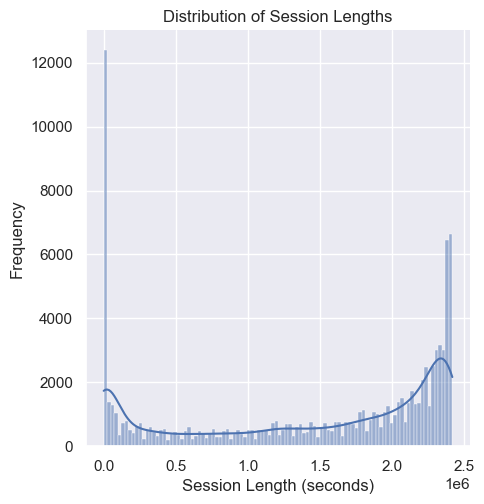

In [16]:
sns.displot(all_dfs_concat_session_length["session_length_secs"], bins=100, kde=True)
plt.title("Distribution of Session Lengths")
plt.xlabel("Session Length (seconds)")
plt.ylabel("Frequency")

In [17]:
top_aid_ordered = all_dfs_concat_actions_count[all_dfs_concat_actions_count.type=='orders'].sort_values('total_types', ascending=False)[:100]
top_aid_carts = all_dfs_concat_actions_count[all_dfs_concat_actions_count.type=='carts'].sort_values('total_types', ascending=False)[:100]

In [ ]:
(set(top_aid_carts['aid']).intersection(set(top_aid_ordered['aid'])))

In [19]:
top_aids_cart_no_order = (set(top_aid_carts['aid']).difference(set(top_aid_ordered['aid'])))

In [ ]:
top_aids_cart_no_order

In [59]:
df = all_dfs_concat.copy()
df = df[['aid','type']]

In [60]:
df = df.groupby(['aid','type']).agg(counts=('type','count')).reset_index()

In [61]:
df

,aid,type,counts
0,1,carts,0
1,1,clicks,1
2,1,orders,0
3,3,carts,0
4,3,clicks,13
...,...,...,...
1989232,1855600,clicks,4
1989233,1855600,orders,0
1989234,1855601,carts,0
1989235,1855601,clicks,4


In [69]:
df['pct_act'] = (df['counts']/df.groupby('aid')['counts'].transform('sum'))*100

In [112]:
orders_pct_action = df[(df['type']=='orders') \
    & df.pct_act.between(1,100)
    ].sort_values('pct_act',ascending=False)

In [113]:
orders_pct_action

,aid,type,counts,pct_act
1777031,1657811,orders,1,100.0
148196,138326,orders,1,100.0
1381973,1290597,orders,1,100.0
1328000,1239831,orders,2,100.0
152513,142536,orders,1,100.0
...,...,...,...,...
1908884,1780266,orders,1,1.0
1242521,1160231,orders,1,1.0
1690607,1577268,orders,1,1.0
916319,856301,orders,1,1.0


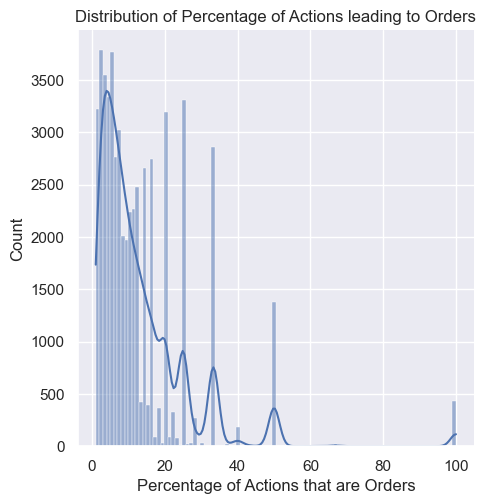

In [114]:
sns.displot(orders_pct_action["pct_act"], bins=100, kde=True)
plt.title("Distribution of Percentage of Actions leading to Orders");
plt.xlabel("Percentage of Actions that are Orders");
# plt.ylabel("Frequency")